In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.cluster import KMeans
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_goldfeldquandt
from statsmodels.graphics.regressionplots import plot_leverage_resid2
from statsmodels.graphics.regressionplots import influence_plot


from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

import tabulate as tabulate

from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

Text(0, 0.5, 'Count')

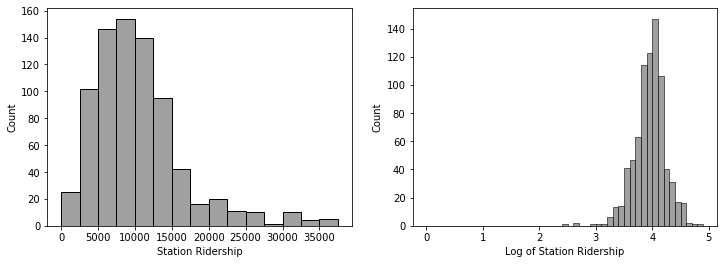

In [2]:
# Load trip data
trips = pd.read_csv("ALL_OSM_Rat2.csv")

# Remove Riverside Museum station
#trips = trips.drop(15)

# Log transform ridership
trips['logcount'] = np.log10(trips['counts'])

# Histograms of ridership
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.histplot(data=trips, x='counts', bins=np.arange(0, 40000, 2500), color='grey', edgecolor='black')
plt.xlabel("Station Ridership")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
sns.histplot(data=trips, x='logcount', bins=np.arange(0, 5, 0.1), color='grey', edgecolor='black')
plt.xlabel("Log of Station Ridership")
plt.ylabel("Count")

In [63]:
trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 788 entries, 0 to 787
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   FID            788 non-null    int64  
 1   EndStationID   788 non-null    int64  
 2   BUS_DIST       788 non-null    float64
 3   METRO_DIST     788 non-null    float64
 4   RAIL_DIST      788 non-null    float64
 5   CAZ_DIST       788 non-null    float64
 6   RetailCoverS   788 non-null    float64
 7   RetailRatio    788 non-null    float64
 8   ResCoverS      788 non-null    float64
 9   ResidentRatio  788 non-null    float64
 10  ParkCoverS     788 non-null    float64
 11  ParkRatio      788 non-null    float64
 12  CommerCoverS   788 non-null    float64
 13  CommerRatio    788 non-null    float64
 14  MetroCommu     680 non-null    float64
 15  BusCommute     680 non-null    float64
 16  Deprivatio     680 non-null    float64
 17  AllusualRe     680 non-null    float64
 18  JobDensity

In [64]:
trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 788 entries, 0 to 787
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   FID            788 non-null    int64  
 1   EndStationID   788 non-null    int64  
 2   BUS_DIST       788 non-null    float64
 3   METRO_DIST     788 non-null    float64
 4   RAIL_DIST      788 non-null    float64
 5   CAZ_DIST       788 non-null    float64
 6   RetailCoverS   788 non-null    float64
 7   RetailRatio    788 non-null    float64
 8   ResCoverS      788 non-null    float64
 9   ResidentRatio  788 non-null    float64
 10  ParkCoverS     788 non-null    float64
 11  ParkRatio      788 non-null    float64
 12  CommerCoverS   788 non-null    float64
 13  CommerRatio    788 non-null    float64
 14  MetroCommu     680 non-null    float64
 15  BusCommute     680 non-null    float64
 16  Deprivatio     680 non-null    float64
 17  AllusualRe     680 non-null    float64
 18  JobDensity

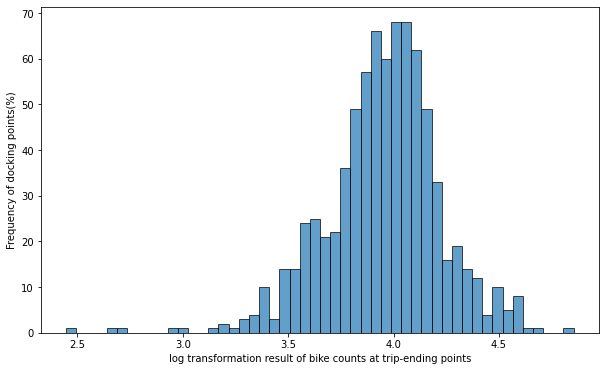

In [65]:
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

plt.hist(trips['logcount'], bins=50, edgecolor='k', alpha=0.7)
plt.xlabel('log transformation result of bike counts at trip-ending points')
plt.ylabel('Frequency of docking points(%)')

# save the img
# plt.savefig('logcount_histogram.jpg', dpi=150, bbox_inches='tight')
# print("saved as'logcount_histogram.jpg'")

plt.show()

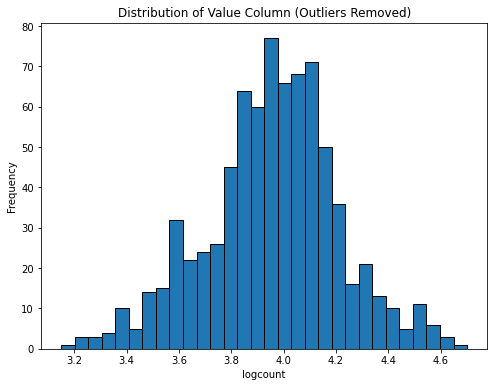

In [66]:
# 计算 'logcount' 列的均值和标准差
mean_value = trips['logcount'].mean()
std_value = trips['logcount'].std()

# 定义阈值，例如，如果离群值超过均值的2倍标准差，则认为是离群值
threshold = 3 * std_value

# 根据阈值去除离群值
trips_cleaned = trips[abs(trips['logcount'] - mean_value) <= threshold]

# 可视化去除离群值后的数据
plt.figure(figsize=(8, 6))
plt.hist(trips_cleaned['logcount'], bins=30, edgecolor='k')
plt.xlabel('logcount')
plt.ylabel('Frequency')
plt.title('Distribution of Value Column (Outliers Removed)')
plt.show()


In [67]:
trips_cleaned.describe()

,FID,EndStationID,BUS_DIST,METRO_DIST,RAIL_DIST,CAZ_DIST,RetailCoverS,RetailRatio,ResCoverS,ResidentRatio,...,JobDensity,StudentRat,NoCar,OfficeWork,CarorVanCo,CycleCommu,RoadDen,counts,count_ratio,logcount
count,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,...,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,782.000000,782.000000,782.000000,782.000000
mean,391.881074,420.506394,158.108199,430.974859,369.896162,3942.021696,35648.935194,0.010117,266103.357867,0.010254,...,0.793263,0.107681,0.665808,0.230670,0.141095,0.096066,0.076525,10726.570332,0.001268,3.957127
std,226.610983,244.900449,157.527481,300.309816,224.575315,2073.667439,34690.819859,0.009845,162821.249230,0.006274,...,0.084422,0.068855,0.114611,0.043751,0.050327,0.035346,0.201392,6723.001607,0.000794,0.255297
min,0.000000,1.000000,4.644980,4.352491,4.082762,169.372207,0.000000,0.000000,0.000000,0.000000,...,0.329748,0.035424,0.322807,0.133794,0.039427,0.018265,0.000000,1412.000000,0.000167,3.149835
25%,196.250000,208.250000,52.598764,197.070932,201.572945,2251.417130,10491.949707,0.002978,124987.242150,0.004816,...,0.754695,0.071238,0.597610,0.200431,0.108023,0.070596,0.015886,6496.000000,0.000768,3.812646
50%,392.500000,427.500000,105.195041,364.761625,342.240821,3710.798546,25652.250000,0.007280,289312.390650,0.011148,...,0.800720,0.092701,0.679563,0.230155,0.141593,0.093248,0.031231,9310.000000,0.001100,3.968950
75%,587.750000,631.750000,207.444836,598.507118,502.983351,5461.264213,47162.025390,0.013385,400194.539100,0.015421,...,0.855119,0.121007,0.744583,0.260539,0.177600,0.117241,0.057469,12970.000000,0.001533,4.112940
max,783.000000,845.000000,881.730394,1433.801432,1195.401746,9017.367554,179076.000000,0.050822,736713.687500,0.028388,...,0.922594,0.635085,0.867347,0.393357,0.301954,0.227811,2.944029,50274.000000,0.005941,4.701343


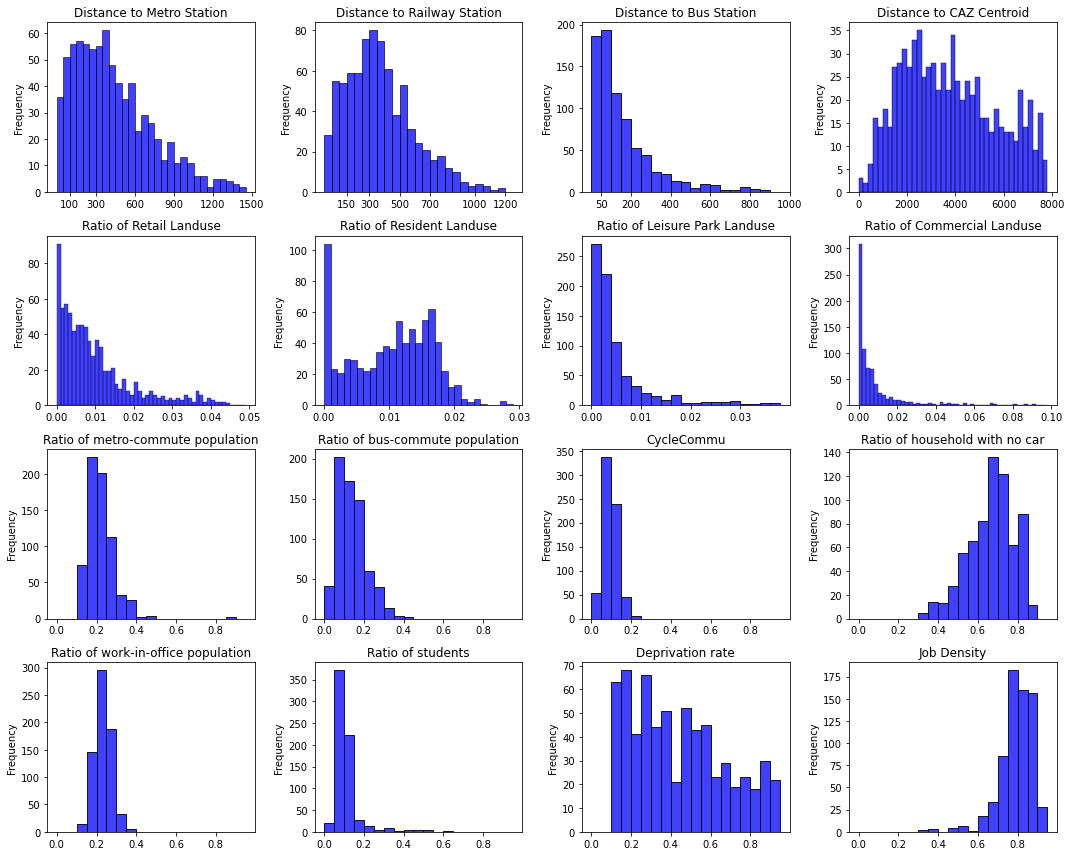

In [68]:
# Box plot of transit station
plt.figure(figsize=(15, 12))

plt.subplot(4, 4, 1)
sns.histplot(data=trips, x='METRO_DIST', bins=np.arange(0, 1500, 50), color='blue', edgecolor='black')
plt.xlabel("")
plt.ylabel("Frequency")
plt.xticks([100, 300, 600, 900, 1200, 1500])
plt.title("Distance to Metro Station")

plt.subplot(4, 4, 2)
sns.histplot(data=trips, x='RAIL_DIST', bins=np.arange(0, 1300, 50), color='blue', edgecolor='black')
plt.xlabel("")
plt.ylabel("Frequency")
plt.xticks([150,300, 500, 700, 1000, 1200])
plt.title("Distance to Railway Station")

plt.subplot(4, 4, 3)
sns.histplot(data=trips, x='BUS_DIST', bins=np.arange(0, 1000, 50), color='blue', edgecolor='black')
plt.xlabel("")
plt.ylabel("Frequency")
plt.xticks([50, 200, 400, 600, 800, 1000])
plt.title("Distance to Bus Station")

plt.subplot(4, 4, 4)
sns.histplot(data=trips, x='CAZ_DIST', bins=np.arange(0, 8000, 200), color='blue', edgecolor='black')
plt.xlabel("")
plt.ylabel("Frequency")
plt.xticks([0, 2000, 4000,6000, 8000])
plt.title("Distance to CAZ Centroid") #Euclidean distance (meter)to central activity zone (CAZ) centre within 500m buffer"

plt.subplot(4, 4, 5)
sns.histplot(data=trips, x='RetailRatio', bins=np.arange(0, 0.05, 0.001), color='blue', edgecolor='black')
plt.xlabel("")
plt.ylabel("Frequency")
#plt.xticks([0, 0.2,0.4,0.6,0.8,1])
plt.title("Ratio of Retail Landuse") #Ratio of Retail Landuse Area within 500m buffer"

plt.subplot(4, 4, 6)
sns.histplot(data=trips, x='ResidentRatio', bins=np.arange(0, 0.03, 0.001), color='blue', edgecolor='black')
plt.xlabel("")
plt.ylabel("Frequency")
#plt.xticks([0,0.005, 0.01,0.015, 0.02,0.025, 0.03])
plt.title("Ratio of Resident Landuse")#Ratio of Resident Landuse Area within 500m buffer"

plt.subplot(4, 4, 7)
sns.histplot(data=trips, x='ParkRatio', bins=np.arange(0, 0.04, 0.002), color='blue', edgecolor='black')
plt.xlabel("")
plt.ylabel("Frequency")
#plt.xticks([0,0.005, 0.01,0.015, 0.02,0.025, 0.03])
plt.title("Ratio of Leisure Park Landuse")#Ratio of Park Landuse Area within 500m buffer"

plt.subplot(4, 4, 8)
sns.histplot(data=trips, x='CommerRatio', bins=np.arange(0, 0.1, 0.002), color='blue', edgecolor='black')
plt.xlabel("")
plt.ylabel("Frequency")
#plt.xticks([0,0.005, 0.01,0.015, 0.02,0.025, 0.03])
plt.title("Ratio of Commercial Landuse")#Ratio of Park Landuse Area within 500m buffer"

plt.subplot(4, 4, 9)
sns.histplot(data=trips, x='MetroCommu', bins=np.arange(0, 1, 0.05), color='blue', edgecolor='black')
plt.xlabel("")
plt.ylabel("Frequency")
#plt.xticks([0,0.005, 0.01,0.015, 0.02,0.025, 0.03])
plt.title("Ratio of metro-commute population")

plt.subplot(4, 4, 10)
sns.histplot(data=trips, x='BusCommute', bins=np.arange(0, 1, 0.05), color='blue', edgecolor='black')
plt.xlabel("")
plt.ylabel("")
#plt.xticks([0,0.005, 0.01,0.015, 0.02,0.025, 0.03])
plt.title("Ratio of bus-commute population")

plt.subplot(4, 4, 11)
sns.histplot(data=trips, x='CycleCommu', bins=np.arange(0, 1, 0.05), color='blue', edgecolor='black')
plt.xlabel("")
plt.ylabel("Frequency")
#plt.xticks([0,0.005, 0.01,0.015, 0.02,0.025, 0.03])
plt.title("CycleCommu")

plt.subplot(4, 4, 12)
sns.histplot(data=trips, x='NoCar', bins=np.arange(0, 1, 0.05), color='blue', edgecolor='black')
plt.xlabel("")
plt.ylabel("Frequency")
#plt.xticks([0,0.005, 0.01,0.015, 0.02,0.025, 0.03])
plt.title("Ratio of household with no car")

plt.subplot(4, 4, 13)
sns.histplot(data=trips, x='OfficeWork', bins=np.arange(0, 1, 0.05), color='blue', edgecolor='black')
plt.xlabel("")
plt.ylabel("Frequency")
plt.title("Ratio of work-in-office population")

plt.subplot(4, 4, 14)
sns.histplot(data=trips, x='StudentRat', bins=np.arange(0, 1, 0.05), color='blue', edgecolor='black')
plt.xlabel("")
plt.ylabel("Frequency")
plt.title("Ratio of students")


plt.subplot(4, 4, 15)
sns.histplot(data=trips, x='Deprivatio', bins=np.arange(0, 1, 0.05), color='blue', edgecolor='black')
plt.xlabel("")
plt.ylabel("Frequency")
plt.title("Deprivation rate")

plt.subplot(4, 4, 16)
sns.histplot(data=trips, x='JobDensity', bins=np.arange(0, 1, 0.05), color='blue', edgecolor='black')
plt.xlabel("")
plt.ylabel("Frequency")
plt.title("Job Density")

# save img
plt.savefig('x_variables.jpg', dpi=200, bbox_inches='tight') 

plt.tight_layout()  # Optional for better layout
plt.show()

Due to unavalability of 2021 London census data of some LSOA areas, the correspoding row of bike trip ending station has null value as well. However, distance relevant variables are still complete for following analysing. So Stations with null value would be imputed rather than removed from this analysis.

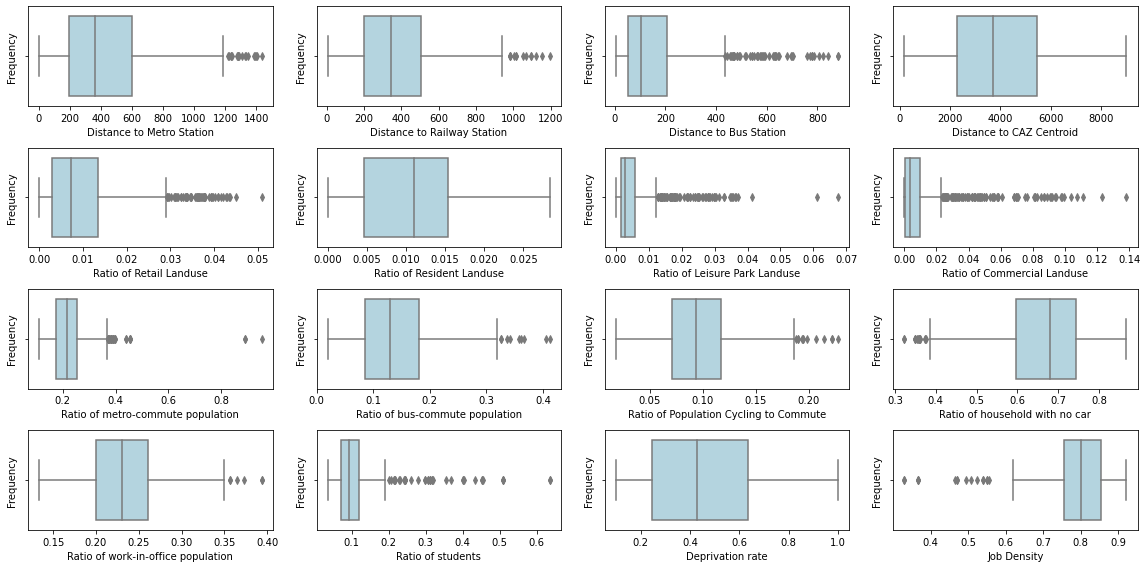

In [8]:

# Assuming you have a DataFrame named trips
# Replace the column names with your actual column names

plt.figure(figsize=(16,8))

plt.subplot(4, 4, 1)
sns.boxplot(data=trips, x='METRO_DIST', color='lightblue')
plt.xlabel("Distance to Metro Station")
plt.ylabel("Frequency")

plt.subplot(4, 4, 2)
sns.boxplot(data=trips, x='RAIL_DIST', color='lightblue')
plt.xlabel("Distance to Railway Station")
plt.ylabel("Frequency")

plt.subplot(4, 4, 3)
sns.boxplot(data=trips, x='BUS_DIST', color='lightblue')
plt.xlabel("Distance to Bus Station")
plt.ylabel("Frequency")

plt.subplot(4, 4, 4)
sns.boxplot(data=trips, x='CAZ_DIST', color='lightblue')
plt.xlabel("Distance to CAZ Centroid")
plt.ylabel("Frequency")

plt.subplot(4, 4, 5)
sns.boxplot(data=trips, x='RetailRatio', color='lightblue')
plt.xlabel("Ratio of Retail Landuse")
plt.ylabel("Frequency")

plt.subplot(4, 4, 6)
sns.boxplot(data=trips, x='ResidentRatio', color='lightblue')
plt.xlabel("Ratio of Resident Landuse")
plt.ylabel("Frequency")

plt.subplot(4, 4, 7)
sns.boxplot(data=trips, x='ParkRatio', color='lightblue')
plt.xlabel("Ratio of Leisure Park Landuse")
plt.ylabel("Frequency")

plt.subplot(4, 4, 8)
sns.boxplot(data=trips, x='CommerRatio', color='lightblue')
plt.xlabel("Ratio of Commercial Landuse")
plt.ylabel("Frequency")

plt.subplot(4, 4, 9)
sns.boxplot(data=trips, x='MetroCommu', color='lightblue')
plt.xlabel("Ratio of metro-commute population")
plt.ylabel("Frequency")

plt.subplot(4, 4, 10)
sns.boxplot(data=trips, x='BusCommute', color='lightblue')
plt.xlabel("Ratio of bus-commute population")
plt.ylabel("Frequency")

plt.subplot(4, 4, 11)
sns.boxplot(data=trips, x='CycleCommu', color='lightblue')
plt.xlabel("Ratio of Population Cycling to Commute")
plt.ylabel("Frequency")

plt.subplot(4, 4, 12)
sns.boxplot(data=trips, x='NoCar', color='lightblue')
plt.xlabel("Ratio of household with no car")
plt.ylabel("Frequency")

plt.subplot(4, 4, 13)
sns.boxplot(data=trips, x='OfficeWork', color='lightblue')
plt.xlabel("Ratio of work-in-office population")
plt.ylabel("Frequency")

plt.subplot(4, 4, 14)
sns.boxplot(data=trips, x='StudentRat', color='lightblue')
plt.xlabel("Ratio of students")
plt.ylabel("Frequency")

plt.subplot(4, 4, 15)
sns.boxplot(data=trips, x='Deprivatio', color='lightblue')
plt.xlabel("Deprivation rate")
plt.ylabel("Frequency")

plt.subplot(4, 4, 16)
sns.boxplot(data=trips, x='JobDensity', color='lightblue')
plt.xlabel("Job Density")
plt.ylabel("Frequency")

# Save img
#plt.savefig('x_variables_boxplot.jpg', dpi=200, bbox_inches='tight') 

plt.tight_layout()
plt.show()


In [69]:
# 创建 SimpleImputer 对象
imputer = SimpleImputer(strategy='most_frequent') 

#拟合模型并进行插补
data_imputed = imputer.fit_transform(trips_cleaned)

#将结果转回 DataFrame格式
trips = pd.DataFrame(data_imputed, columns=trips_cleaned.columns, index=trips_cleaned.index)
trips.describe()

/opt/conda/lib/python3.10/site-packages/sklearn/impute/_base.py:54: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


,FID,EndStationID,BUS_DIST,METRO_DIST,RAIL_DIST,CAZ_DIST,RetailCoverS,RetailRatio,ResCoverS,ResidentRatio,...,JobDensity,StudentRat,NoCar,OfficeWork,CarorVanCo,CycleCommu,RoadDen,counts,count_ratio,logcount
count,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,...,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000
mean,391.881074,420.506394,158.108199,430.974859,369.896162,3942.021696,35648.935194,0.010117,266103.357867,0.010254,...,0.788999,0.107926,0.688886,0.229646,0.127871,0.090903,0.076525,10726.570332,0.001268,3.957127
std,226.610983,244.900449,157.527481,300.309816,224.575315,2073.667439,34690.819859,0.009845,162821.249230,0.006274,...,0.079155,0.063967,0.121244,0.040725,0.057363,0.035306,0.201392,6723.001607,0.000794,0.255297
min,0.000000,1.000000,4.644980,4.352491,4.082762,169.372207,0.000000,0.000000,0.000000,0.000000,...,0.329748,0.035424,0.322807,0.133794,0.039427,0.018265,0.000000,1412.000000,0.000167,3.149835
25%,196.250000,208.250000,52.598764,197.070932,201.572945,2251.417130,10491.949707,0.002978,124987.242150,0.004816,...,0.762105,0.075643,0.614023,0.206409,0.080514,0.058333,0.015886,6496.000000,0.000768,3.812646
50%,392.500000,427.500000,105.195041,364.761625,342.240821,3710.798546,25652.250000,0.007280,289312.390650,0.011148,...,0.787251,0.100896,0.699501,0.223187,0.133739,0.088606,0.031231,9310.000000,0.001100,3.968950
75%,587.750000,631.750000,207.444836,598.507118,502.983351,5461.264213,47162.025390,0.013385,400194.539100,0.015421,...,0.847042,0.116491,0.805145,0.255861,0.169814,0.112676,0.057469,12970.000000,0.001533,4.112940
max,783.000000,845.000000,881.730394,1433.801432,1195.401746,9017.367554,179076.000000,0.050822,736713.687500,0.028388,...,0.922594,0.635085,0.867347,0.393357,0.301954,0.227811,2.944029,50274.000000,0.005941,4.701343


In [72]:
# 使用describe()函数获取描述性统计信息
describe_stats = trips.describe()

# 选择要保留的列
rows_to_keep = ['mean', 'min', 'max', 'std']

# 从describe_stats中提取所需的列
selected_stats = describe_stats.loc[rows_to_keep]

# 将结果保存为CSV文件
selected_stats.to_csv('trip_describe_summary.csv')

In [41]:
'''
# 选择需要标准化的列
columns_to_standardize = ['RetailRatio','CommerRatio', 'ResidentRatio', 'ParkRatio', 'METRO_DIST', 'CAZ_DIST', 'ResCoverS', 'BUS_DIST', 'RetailCoverS', 'ParkCoverS', 'CommerCoverS']

# 创建StandardScaler对象并进行标准化
scaler = MinMaxScaler()
trips[columns_to_standardize] = scaler.fit_transform(trips[columns_to_standardize])


# 输出前几行数据以确认修改已生效
trips.head()
'''

,FID,EndStationID,BUS_DIST,METRO_DIST,RAIL_DIST,CAZ_DIST,RetailCoverS,RetailRatio,ResCoverS,ResidentRatio,...,NoCar,OfficeWork,MetroCommu.1,BusCommute.1,CarorVanCo,CycleCommu,RoadDen,counts,count_ratio,logcount
0,591,1,0.268152,0.350619,459.626131,0.205535,0.165210,0.165210,0.515733,0.515733,...,0.647059,0.240000,0.175000,0.158333,0.155556,0.108333,0.006901,3758,0.000444,3.574957
1,254,2,0.071575,0.257308,387.149307,0.177583,0.116218,0.116218,0.085651,0.085651,...,0.422735,0.136395,0.175879,0.075377,0.216080,0.090452,0.013419,15333,0.001812,4.185627
2,605,3,0.096885,0.276446,410.602950,0.274569,0.219353,0.219353,0.410694,0.410694,...,0.854701,0.230155,0.245370,0.097222,0.069444,0.155093,0.011469,7665,0.000906,3.884512
3,631,4,0.074240,0.063155,215.292830,0.312585,0.373940,0.373940,0.438245,0.438245,...,0.815409,0.234731,0.231975,0.172414,0.128527,0.103448,0.004860,7055,0.000834,3.848497
4,181,5,0.057739,0.060014,122.144978,0.246289,0.029306,0.029306,0.128732,0.128732,...,0.579027,0.207200,0.216216,0.081081,0.127413,0.061776,0.005243,20532,0.002426,4.312431


### Lasso Regression

In [34]:

# Lasso Regression
# Select columns with 11 independent variables & dependent logcount
selected_columns = ['BUS_DIST','METRO_DIST','RAIL_DIST','CAZ_DIST','RetailCoverS','ResCoverS','ParkCoverS','CommerCoverS','Deprivatio','OfficeWork','CycleCommu','NoCar','RoadDen', 'logcount']
trips_selection = trips[selected_columns]

# Split into predictor variables (X) and outcome variable (y)
X = trips_selection.drop('logcount', axis=1)
y = trips_selection['logcount']

# Perform Lasso regression with cross-validation to find the best alpha (lambda) value
lasso = LassoCV(alphas=np.logspace(-4, 4, 100), cv=5, random_state=123)
lasso.fit(X, y)

# Display the best alpha (lambda) value
best_alpha = lasso.alpha_
print("Best Alpha (Lambda):", best_alpha)

# Train the final Lasso model with the best alpha (lambda) value
lasso_final = LassoCV(alphas=[best_alpha], cv=5, random_state=123)
lasso_final.fit(X, y)

# Display regression coefficients
lasso_coef = pd.DataFrame({'Variable': X.columns, 'Coefficient': lasso_final.coef_})
print(lasso_coef)


Best Alpha (Lambda): 0.000774263682681127
        Variable   Coefficient
0       BUS_DIST -1.211753e-04
1     METRO_DIST -1.041300e-04
2      RAIL_DIST -1.926313e-06
3       CAZ_DIST -2.277087e-07
4   RetailCoverS  6.675844e-08
5      ResCoverS -1.872906e-07
6     ParkCoverS  2.301329e-07
7   CommerCoverS  2.776402e-07
8     Deprivatio -8.018815e-02
9     OfficeWork -0.000000e+00
10    CycleCommu  0.000000e+00
11         NoCar  2.848823e-01
12       RoadDen -7.406772e-02


以上步骤用lasso regression初步筛选出相关系数为0的变量。Office-work population ratio 和 Cycle to Commute population ratio 这两个变量被剔除后，其他自变量被加入斯皮尔曼回归分析。<br>
The above steps were used in lasso regression to initially screen out variables with a correlation coefficient of zero." Office-work population ratio" and "Cycle to Commute population ratio" were eliminated and the other independent variables were added to the Spearman regression analysis.

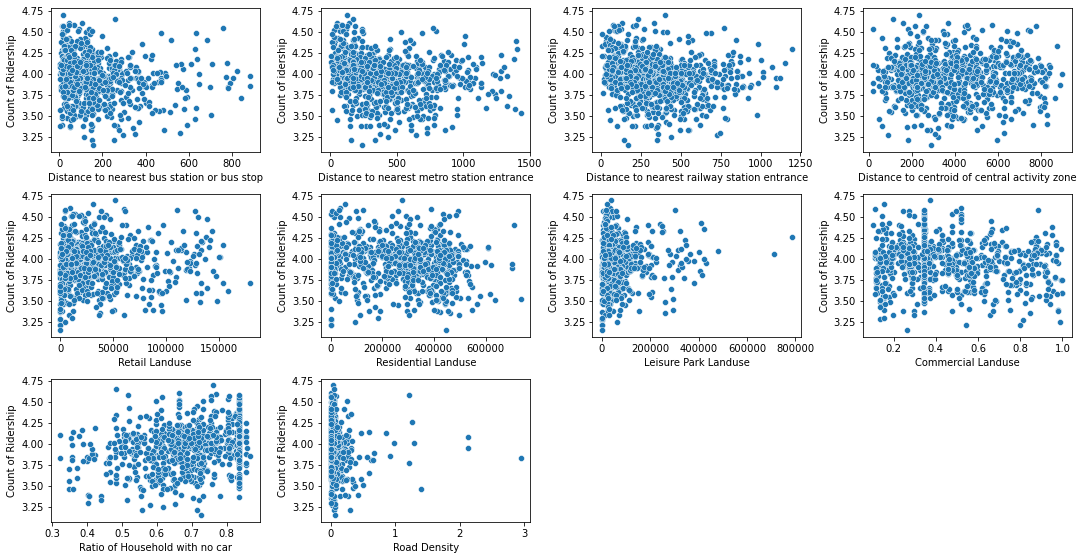

In [42]:
# Scatterplots for selected variables
plt.figure(figsize=(15, 10))

plt.subplot(4, 4, 1)
sns.scatterplot(data=trips, x='BUS_DIST', y='logcount')
plt.xlabel("Distance to nearest bus station or bus stop")
plt.ylabel("Count of Ridership")

plt.subplot(4, 4, 2)
sns.scatterplot(data=trips, x='METRO_DIST', y='logcount')
plt.xlabel("Distance to nearest metro station entrance")
plt.ylabel("Count of idership")

plt.subplot(4, 4, 3)
sns.scatterplot(data=trips, x='RAIL_DIST', y='logcount')
plt.xlabel("Distance to nearest railway station entrance")
plt.ylabel("Count of idership")

plt.subplot(4, 4, 4)
sns.scatterplot(data=trips, x='CAZ_DIST', y='logcount')
plt.xlabel("Distance to centroid of central activity zone")
plt.ylabel("Count of idership")


plt.subplot(4, 4, 5)
sns.scatterplot(data=trips, x='RetailCoverS', y='logcount')
plt.xlabel("Retail Landuse") # Retail Land Use Area that falls within a 500-meter buffer zone or area
plt.ylabel("Count of Ridership")

plt.subplot(4, 4, 6)
sns.scatterplot(data=trips, x='ResCoverS', y='logcount')
plt.xlabel("Residential Landuse")# Residential Land Use Area that falls within a 500-meter buffer zone or area
plt.ylabel("Count of Ridership")

plt.subplot(4, 4, 7)
sns.scatterplot(data=trips, x='ParkCoverS', y='logcount')
plt.xlabel("Leisure Park Landuse")# Leisure Park Land Use Area that falls within a 500-meter buffer zone or area
plt.ylabel("Count of Ridership")

plt.subplot(4, 4, 8)
sns.scatterplot(data=trips, x='Deprivatio', y='logcount')
plt.xlabel("Commercial Landuse")# Commercial Land Use Area that falls within a 500-meter buffer zone or area
plt.ylabel("Count of Ridership")

plt.subplot(4, 4, 9)
sns.scatterplot(data=trips, x='NoCar', y='logcount')
plt.xlabel("Ratio of Household with no car")# Commercial Land Use Area that falls within a 500-meter buffer zone or area
plt.ylabel("Count of Ridership")

plt.subplot(4, 4, 10)
sns.scatterplot(data=trips, x='RoadDen', y='logcount')
plt.xlabel("Road Density")# Commercial Land Use Area that falls within a 500-meter buffer zone or area
plt.ylabel("Count of Ridership")

plt.tight_layout()
plt.show()

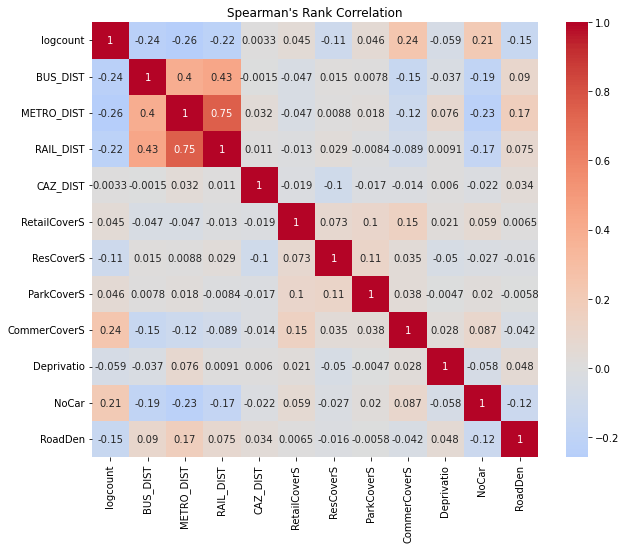

'\n# Calculate Spearman\'s rank correlation\ncorrelation_matrix = trips.corr(method=\'spearman\')\nplt.figure(figsize=(10, 8))\nsns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)\nplt.title("Spearman\'s Rank Correlation")\nplt.show()\n'

In [39]:
# Select the columns of interest
columns_of_interest = ['logcount', 'BUS_DIST', 'METRO_DIST', 'RAIL_DIST', 'CAZ_DIST', 'RetailCoverS',
                       'ResCoverS', 'ParkCoverS', 'CommerCoverS', 'Deprivatio', 'NoCar', 'RoadDen']

# Calculate Spearman's rank correlation for the selected columns
correlation_matrix = trips[columns_of_interest].corr(method='spearman')

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Spearman's Rank Correlation")
plt.show()

'''
# Calculate Spearman's rank correlation
correlation_matrix = trips.corr(method='spearman')
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Spearman's Rank Correlation")
plt.show()
'''

In [40]:
# Check multicollinearity
X_selected = trips[['BUS_DIST','METRO_DIST','RAIL_DIST','CAZ_DIST','RetailCoverS','CommerCoverS','RoadDen']]
vif = pd.DataFrame()
vif["Features"] = X_selected.columns
vif["VIF Factor"] = [variance_inflation_factor(X_selected.values, i) for i in range(X_selected.shape[1])]
print(vif)

       Features  VIF Factor
0      BUS_DIST    2.886186
1    METRO_DIST    5.793581
2     RAIL_DIST    7.497189
3      CAZ_DIST    2.848711
4  RetailCoverS    1.873658
5  CommerCoverS    1.279695
6       RoadDen    1.170149


By analyzing the VIF values for the remaining variables, "Distance to railway station" variable was observed a high VIF value of 7.497, attributed to the fact that it has a high correlation with  "Distance to metro station" (0.75), and "Distance to bus station" (0.43). Therefore,  "Distance to railway station" was removed from the final lasso regression model.

In [43]:
columns_to_keep = ['logcount', 'BUS_DIST','METRO_DIST','CAZ_DIST','RetailCoverS','ResCoverS','ParkCoverS','CommerCoverS','Deprivatio','NoCar','RoadDen']

# 使用 .loc[] 选择要保留的列
trips = trips.loc[:, columns_to_keep]

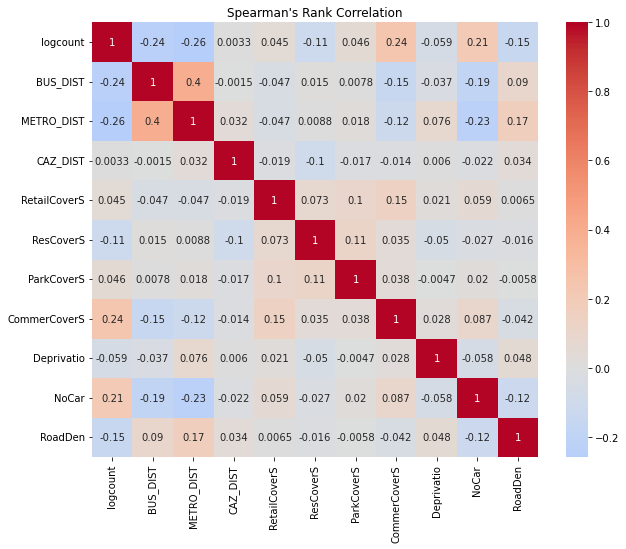

In [44]:
# Check Spearman's rank correlation again
correlation_matrix = trips.corr(method='spearman')
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Spearman's Rank Correlation")
plt.show()

In [45]:
# Check multicollinearity again
X_selected = trips[['BUS_DIST','METRO_DIST']]
vif = pd.DataFrame()
vif["Features"] = X_selected.columns
vif["VIF Factor"] = [variance_inflation_factor(X_selected.values, i) for i in range(X_selected.shape[1])]
print(vif)

     Features  VIF Factor
0    BUS_DIST    2.375411
1  METRO_DIST    2.375411


In [47]:
## Final Lasso Regression

# Define the independent variables and the dependent variable
X = trips[['BUS_DIST', 'METRO_DIST', 'CAZ_DIST', 'RetailCoverS','ResCoverS','ParkCoverS','CommerCoverS','Deprivatio','NoCar','RoadDen']]
y = trips['logcount']

# Add an intercept term
X = sm.add_constant(X)

# Create and fit the linear regression model
lm_all = sm.OLS(y, X).fit()

# Create a table of regression results
regression_table = tabulate.tabulate(lm_all.summary().tables[1], headers='keys', tablefmt='pretty')

# Display the regression table
print(regression_table)


+--------------+------------+----------+--------+-------+-----------+-----------+
|      0       |     1      |    2     |   3    |   4   |     5     |     6     |
+--------------+------------+----------+--------+-------+-----------+-----------+
|              |    coef    | std err  |   t    | P>|t| |  [0.025   |  0.975]   |
|    const     |   3.8516   |  0.067   | 57.112 | 0.000 |   3.719   |   3.984   |
|   BUS_DIST   |  -0.0001   | 6.31e-05 | -1.787 | 0.074 |  -0.000   | 1.11e-05  |
|  METRO_DIST  |  -0.0001   | 3.26e-05 | -3.091 | 0.002 |  -0.000   | -3.68e-05 |
|   CAZ_DIST   | -6.196e-08 | 4.23e-06 | -0.015 | 0.988 | -8.36e-06 | 8.24e-06  |
| RetailCoverS | 7.216e-08  | 2.53e-07 | 0.285  | 0.776 | -4.24e-07 | 5.69e-07  |
|  ResCoverS   | -1.885e-07 | 5.4e-08  | -3.491 | 0.001 | -2.94e-07 | -8.25e-08 |
|  ParkCoverS  | 2.315e-07  | 1.02e-07 | 2.259  | 0.024 | 3.03e-08  | 4.33e-07  |
| CommerCoverS | 2.803e-07  | 1.04e-07 | 2.706  | 0.007 | 7.69e-08  | 4.84e-07  |
|  Deprivatio  |

The lasso regression results show that the distance to the nearest bus station (m), nearest metro station (m), the population density and university percentage variables are not significant at the 95% level of confidence. However, ratio of household with no car is significant at the 97.5% level of confidence, while the distance to the nearest metro station ranked second in the p-value performance.

Examining the variables in more detail shows that there is some positive correlation between bike parking counts at docking points and area of leisure park within 500m buffer area, as well as commercial and retail landuse. Besideds, there is some negative correlation between bike parking counts at docking points and road density around the station, also distance to central activity zone centre and deprivation rate of the corresonding LSOA area. However, the strength of the association appears relatively low.

### Stepwise Regression

For comparison, the second model-stepwise regression was built. Both forward and backward selection were checked by using AIC criterion, and backward selection was found a better model accuracy and fit. 

In [49]:
# Import necessary libraries

# Stepwise Regression
# Full model
X = trips.drop(columns=['logcount'])
X = sm.add_constant(X)
y = trips['logcount']
full_model = sm.OLS(y, X).fit()

# Backward stepwise selection using AIC criterion
step_model = full_model
while True:
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    max_vif = vif[vif['Variable'] != 'const']['VIF'].max()
    
    if max_vif > 10:  # You can adjust the VIF threshold as needed
        remove_variable = vif[vif['VIF'] == max_vif]['Variable'].values[0]
        X = X.drop(columns=[remove_variable])
        step_model = sm.OLS(y, X).fit()
    else:
        break

# Display the stepwise regression summary
print(step_model.summary())

# Check for multicollinearity (VIF)
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("VIF:")
print(vif)


                            OLS Regression Results                            
Dep. Variable:               logcount   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     10.02
Date:                Fri, 08 Sep 2023   Prob (F-statistic):           6.16e-16
Time:                        22:31:19   Log-Likelihood:                 6.3685
No. Observations:                 782   AIC:                             9.263
Df Residuals:                     771   BIC:                             60.54
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            3.8516      0.067     57.112   

### Stepwise regression removing outliers 

Lastly, to further verify the significance of the variables, we ran a stepwise regression model with the three ‘outlier stations’ removed – the three stations with the highest number of trips. 


In [51]:
# Import necessary libraries
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


# Stepwise Regression after removing outliers
X1 = trips.drop(columns=['logcount'])
X1 = sm.add_constant(X1)
y1 = trips['logcount']
full_model= sm.OLS(y1, X1).fit()

# Backward stepwise selection using AIC criterion
step_model = full_model
while True:
    vif = pd.DataFrame()
    vif["Variable"] = X1.columns
    vif["VIF"] = [variance_inflation_factor(X1.values, i) for i in range(X1.shape[1])]
    max_vif = vif[vif['Variable'] != 'const']['VIF'].max()
    
    if max_vif > 5:  # You can adjust the VIF threshold as needed
        remove_variable = vif[vif['VIF'] == max_vif]['Variable'].values[0]
        X1 = X1.drop(columns=[remove_variable])
        step_model = sm.OLS(y1, X1).fit()
    else:
        break

# Display the stepwise regression summary
print(step_model.summary())

# Check for multicollinearity (VIF)
vif = pd.DataFrame()
vif["Variable"] = X1.columns
vif["VIF"] = [variance_inflation_factor(X1.values, i) for i in range(X1.shape[1])]
print("VIF:")
print(vif)


                            OLS Regression Results                            
Dep. Variable:               logcount   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     10.02
Date:                Fri, 08 Sep 2023   Prob (F-statistic):           6.16e-16
Time:                        22:37:28   Log-Likelihood:                 6.3685
No. Observations:                 782   AIC:                             9.263
Df Residuals:                     771   BIC:                             60.54
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            3.8516      0.067     57.112   

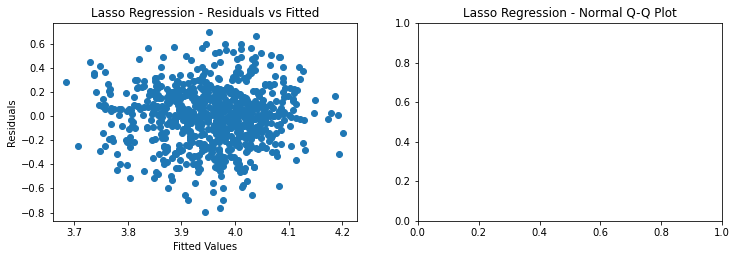

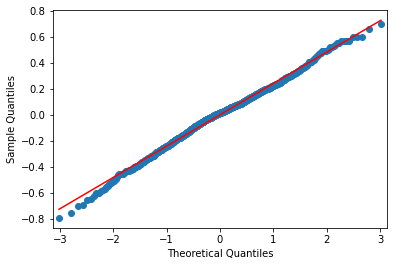

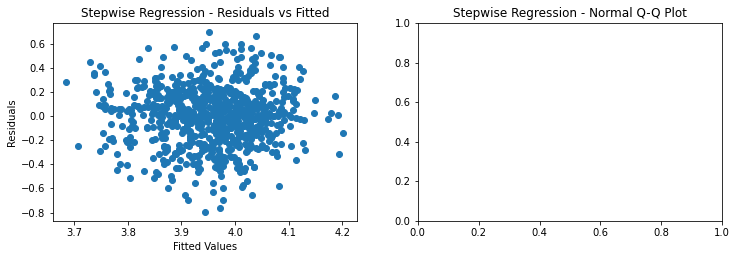

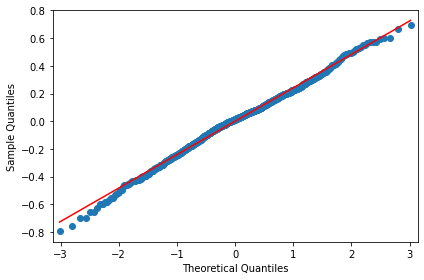

In [52]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Lasso regression
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.title("Lasso Regression - Residuals vs Fitted")
plt.scatter(lm_all.fittedvalues, lm_all.resid)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")

# Stepwise regression
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 2)
plt.title("Stepwise Regression - Residuals vs Fitted")
plt.scatter(step_model.fittedvalues, step_model.resid)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")


plt.tight_layout()
plt.show()


Overall, we can conclude from this regression analysis that in London Santander Service Area. Increased distances to bus sation and the city center are associated with lower bike-sharing demand. Additionally, bike-sharing ridership is significantly higher among populations that have fewer employment deprived residents, and in areas with a higher proportion of cycling lanes. 

In [ ]:


# Perform stepwise regression removing outliers
outlier_indices = [10, 12, 13]
trips_removed_outliers = trips.drop(outlier_indices)
step_model_removed_outliers = ols('logcount ~ ST_DIST + DOWNTOWN_DIST + CYL_PER1 + employment + uni + population_density', data=trips_removed_outliers).fit().step(direction='both', verbose=0)
print(step_model_removed_outliers.summary())

Fitting the Lasso regression model: 拟合Lasso回归模型：使用Lasso回归模型拟合你的数据，并计算AIC值。

In [57]:
lm_all = Lasso(alpha=0.01)  # Adjust alpha as needed
lm_all.fit(X, y)  # X为特征矩阵，y为目标变量
lasso_aic = 2 * X.shape[0] - 2 * lm_all.score(X, y)

Fit a stepwise regression model: 使用逐步回归模型（可以使用statsmodels库中的OLS模型）拟合你的数据，并计算AIC值。

In [56]:
X_with_const = sm.add_constant(X)  # Add a constant term (intercept)
step_model = sm.OLS(y, X_with_const).fit()
step_aic = step_model.aic

Compare AIC values：比较Lasso回归模型和逐步回归模型的AIC值，AIC值越小越好，表示模型对数据的拟合越好。 comparing the AIC values of the Lasso regression model and the stepwise regression model, the smaller the AIC value, the better it indicates that the model fits the data better.

In [60]:

if lasso_aic < step_aic:
    print("Lasso Regression is preferred with AIC =", lasso_aic)
else:
    print("Stepwise Regression is preferred with AIC =", step_aic)

Stepwise Regression is preferred with AIC = 9.262956287940597
